### Projet 9 : Prédisez la demande en électricité

#### Prérequis

Pour effectuer ce projet, vous devrez maîtriser la manipulation de données en Python ou R, connaître la modélisation de type régression linéaire, ainsi que les différentes modélisations de séries temporelles (AR, MA, ARMA, ARIMA, etc.)

#### Mise en situation

Vous êtes employé chez Enercoop, société coopérative qui s'est développée grâce à la libéralisation du marché de l’électricité en France. Elle est spécialisée dans les énergies renouvelables.

La plupart de ces énergies renouvelables est cependant intermittente, il est donc difficile de prévoir les capacités de production d'électricité. De plus, la demande en électricité des utilisateurs varie au cours du temps, et dépend de paramètres comme la météo (température, luminosité, etc.) Tout le challenge est de mettre en adéquation l'offre et la demande !

#### Les données
Vous téléchargerez les données mensuelles de consommation totale d'électricité en énergie à partir de cette page.

Les données météo que vous utiliserez pour corriger les données de l'effet température sont présentes ici : https://cegibat.grdf.fr/simulateur/calcul-dju

#### Vos missions
Vous vous concentrerez uniquement sur la prédiction de la demande en électricité.

1. Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.

2. Effectuez une désaisonnalisation de la consommation que vous aurez obtenue après correction, grâce aux moyennes mobiles.

3. Effectuez une prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temporelle.

In [1]:
#Importations librairies python
import pandas as pd
import numpy as np 
import seaborn as sns
import os
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import ProbPlot
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import scipy.stats as st
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from tqdm import tqdm_notebook
from time import time
import warnings
warnings.filterwarnings('ignore')
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Mission 1 
Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire

In [2]:
#Paramètres de style
pylab.style.use('fivethirtyeight') 
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 10),
          'lines.linewidth': 1.5,
          'axes.labelsize': 'x-large',
          'axes.titlesize':35,
          'axes.titleweight':'bold',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [3]:
#Importation du dataset : données mensuelles de consommation totale d'électricité 
data = pd.read_csv(r"C:\Users\elodi\Downloads\data.csv", sep=';', parse_dates=[0])
data.head()

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Production bioénergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique
0,2012-01-01,Données définitives,France,57177,42811.0,5399,741.0,691,3967,6741,...,514,51086,5371.0,7043.0,1672.0,929.0,724.0,1581.0,2195.0,-59.0
1,2012-02-01,Données définitives,France,54419,38661.0,8721,2511.0,1309,4901,5244,...,454,54476,-715.0,4504.0,5220.0,-798.0,-309.0,1244.0,1579.0,-2430.0
2,2012-03-01,Données définitives,France,48583,37549.0,5276,1435.0,666,3175,3894,...,531,43156,4888.0,7042.0,2153.0,583.0,330.0,1742.0,2235.0,-1.0
3,2012-04-01,Données définitives,France,44192,33100.0,3484,1655.0,486,1343,5302,...,405,40176,3447.0,5762.0,2314.0,547.0,-9.0,1271.0,1670.0,-31.0
4,2012-05-01,Données définitives,France,40433,29058.0,1772,854.0,368,549,7706,...,469,35257,4425.0,6391.0,1965.0,693.0,251.0,1341.0,1060.0,1079.0


In [4]:
data.shape

(1260, 22)

Création d'un jeu de données mensuelles de consommation totale d'électricité en énergie 

In [5]:
df_conso = data.copy()
df_conso = df_conso[df_conso['Territoire'] == 'France']
df_conso = df_conso[['Mois','Consommation totale']]
df_conso.rename(columns={'Mois': 'mois', 'Consommation totale': 'consommation'}, inplace=True)

display(df_conso.head())
display(df_conso.shape)

,mois,consommation
0,2012-01-01,51086
1,2012-02-01,54476
2,2012-03-01,43156
3,2012-04-01,40176
4,2012-05-01,35257


(108, 2)

In [6]:
print(df_conso.isnull().sum())

mois            0
consommation    0
dtype: int64


In [7]:
#Changement du type de Series en datetime
#Changement d'index
df_conso['mois'] = pd.to_datetime(df_conso['mois'])
df_conso.set_index('mois', inplace=True)
df_conso.head()

,consommation
mois,
2012-01-01,51086
2012-02-01,54476
2012-03-01,43156
2012-04-01,40176
2012-05-01,35257


Visualisation de la consommation totale d'énergie

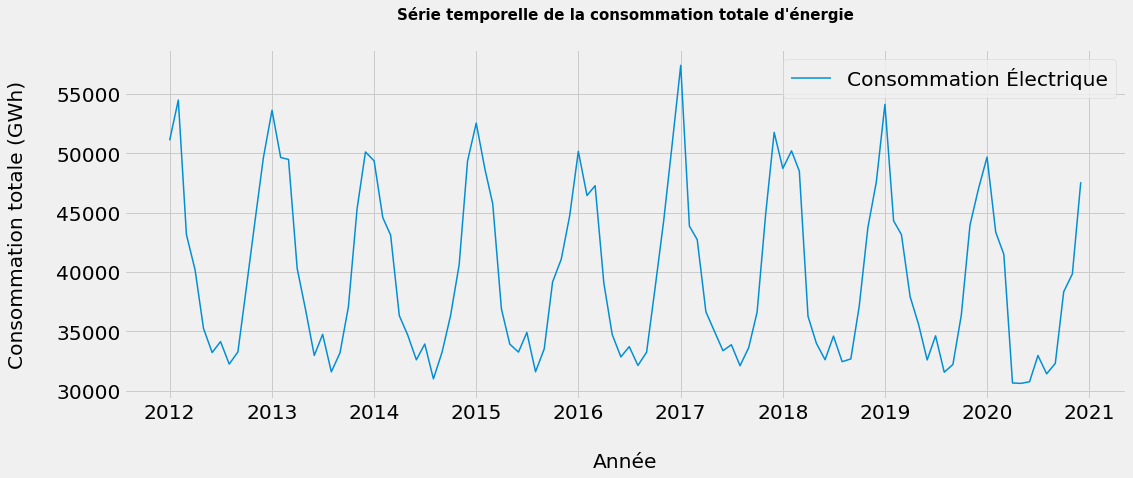

In [8]:
plt.figure(figsize=(16,6))

sns.lineplot(data=df_conso, x='mois', y='consommation')
plt.xlabel('Année', labelpad=30)
plt.ylabel('Consommation totale (GWh)', labelpad=30)
plt.legend(labels=['Consommation Électrique'])

plt.title('Série temporelle de la consommation totale d\'énergie', fontsize=15, pad=30)
plt.savefig('01. Consommation totale electricite en France.png')
plt.show()

Dans la série temporelle ci-dessus on peut identifier des cycles assez réguliers au cours du temps et de même amplitude.

#### Données météo utilisées pour corriger les données de l'effet température
Chargement et traitement des données

In [9]:
#Repertoire actuelle(CWD)
cwd = os.getcwd()
     
#Changement de CWD
cwd = os.chdir(cwd + '/P9_datasets/data')

#Obtention de tous les fichiers nécessaires
files = [file for file in os.listdir(cwd) if file.startswith("calcul_")]

print ("Les fichiers téléchargés depuis le site internet CEGIBAT (Centre EDF-GDF d'Information du Batiment) sont : ")
print("")
for file in files :
    print (file)

Les fichiers téléchargés depuis le site internet CEGIBAT (Centre EDF-GDF d'Information du Batiment) sont : 

calcul_DJU_18_07_2022_bordeaux.xlsx
calcul_DJU_18_07_2022_larochelle.xlsx
calcul_DJU_18_07_2022_macon.xlsx
calcul_DJU_18_07_2022_mende.xlsx
calcul_DJU_18_07_2022_montpellier.xlsx
calcul_DJU_18_07_2022_orly.xlsx
calcul_DJU_18_07_2022_saint_brieux.xlsx
calcul_DJU_18_07_2022_strasbourg.xlsx


In [10]:
#Lecture et concat des différents fichiers
dju = pd.DataFrame()

for file in files :
    data = pd.read_excel(file, header=11, index_col=0)
    dju = pd.concat((dju,data))
    
#clean 
del cwd, file, files, data, 

Transformation des données 

In [11]:
dju = dju.groupby(dju.index).mean()
dju

,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC,Total
2010,498.9750,381.1625,327.1625,187.1250,149.3250,40.3875,4.0750,18.6375,71.9375,186.0750,302.3750,481.8875,2648.8625
2011,414.7250,314.6500,277.6750,112.5875,63.8375,45.8750,31.5125,16.4125,26.2000,136.1000,222.6625,324.4500,1986.4125
2012,370.7375,469.4625,239.1000,235.5375,98.3875,35.4125,20.1250,6.2625,62.5125,151.3250,275.2625,358.3375,2322.1750
2013,418.4625,407.1875,350.2125,224.7875,175.4125,57.4375,4.8375,10.6625,46.9500,107.4375,306.0750,368.8875,2478.0750
2014,335.3125,292.5375,263.4375,158.2375,119.7500,24.8750,14.8375,27.9125,30.7500,86.4500,216.5375,371.5750,1941.9625
2015,393.3625,377.4125,282.2125,169.8500,95.2250,23.8375,8.6625,13.0375,77.5500,182.7625,212.7750,268.8875,2105.3250
2016,351.2875,318.1875,322.3250,221.2500,113.6000,34.4000,12.2750,8.2500,24.1750,179.9750,281.6625,385.5500,2252.7375
2017,478.2750,285.6125,225.5875,203.0250,88.0750,18.7375,7.2250,14.7750,76.8125,112.2125,300.4375,387.2875,2197.8375
2018,307.9375,419.7875,318.5750,145.3625,84.3000,18.5875,1.8625,9.4750,31.8000,132.6500,267.7125,326.0000,2063.8000
2019,424.8625,281.7750,254.3500,203.8750,138.8875,34.7875,3.9125,5.6375,36.1375,110.6500,294.0250,319.8500,2108.5250


In [12]:
dju = pd.DataFrame(dju.stack()).reset_index()

dju['level_0'] = dju['level_0'].astype(object)

dju['level_1'] = dju['level_1'].replace({'JAN' : 1, 
                                         'FÉV' : 2, 
                                         'MAR' : 3,
                                         'AVR' : 4,
                                         'MAI' : 5,
                                         'JUN' : 6,
                                         'JUI' : 7,
                                         'AOÛ' : 8,
                                         'SEP' : 9,
                                         'OCT' : 10,
                                         'NOV' : 11,
                                         'DÉC' : 12})

dju['mois'] = 0

for i in range(0, len(dju)) : 
    dju.loc[i, 'mois'] = str(dju['level_0'][i]) + ' - ' + str(dju['level_1'][i])
    i += 1
    

    
dju = dju[dju['level_1'] != 'Total']

dju['mois'] = dju['mois'].astype('datetime64')

dju = dju[['mois', 0]].rename(columns={0 : 'DJU'})

In [13]:
#Merge df_conso et DJU
df_conso = df_conso.merge(dju, on='mois', how='left')

df_conso = df_conso.set_index('mois')

#Renomer colonnes
df_conso = df_conso.rename(columns={'consommation': 'Consommation'})

df_conso

,Consommation,DJU
mois,,
2012-01-01,51086,370.7375
2012-02-01,54476,469.4625
2012-03-01,43156,239.1000
2012-04-01,40176,235.5375
2012-05-01,35257,98.3875
...,...,...
2020-08-01,31428,8.0250
2020-09-01,32307,43.1125
2020-10-01,38332,166.9625


In [14]:
print(df_conso.isnull().sum())

Consommation    0
DJU             0
dtype: int64


#### Visualisation
Données mensuelles du DJU

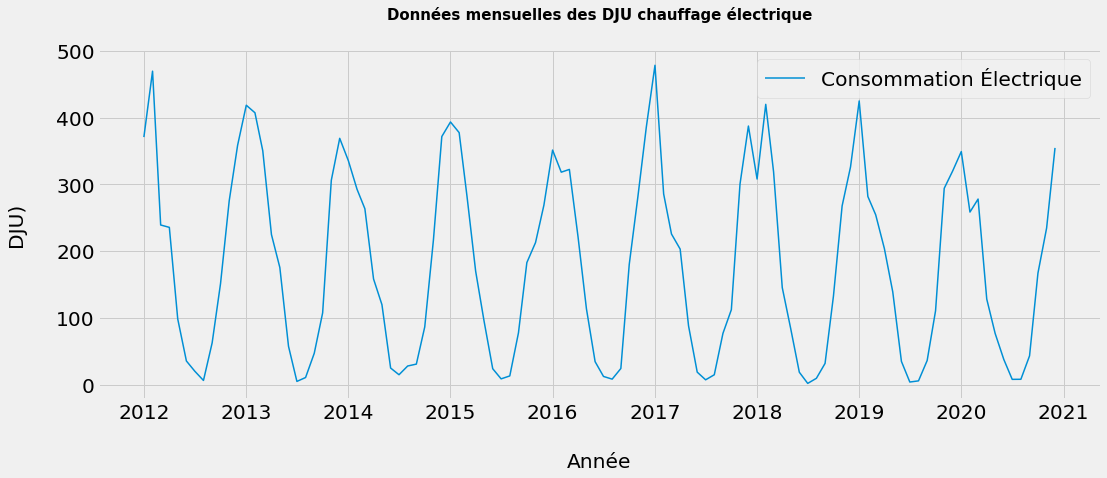

In [15]:
plt.figure(figsize=(16,6))

sns.lineplot(data=df_conso, x='mois', y='DJU')
plt.xlabel('Année', labelpad=30)
plt.ylabel('DJU)', labelpad=30)
plt.legend(labels=['Consommation Électrique'])

plt.title('Données mensuelles des DJU chauffage électrique', fontsize=15, pad=30)
plt.savefig('02. Données mensuelles DJU.png')
plt.show()

Cette série temporelle prend naturellement en compte la saisonnalité liée aux conditions climatiques.

Evolution du DJU et consommation en énergie France

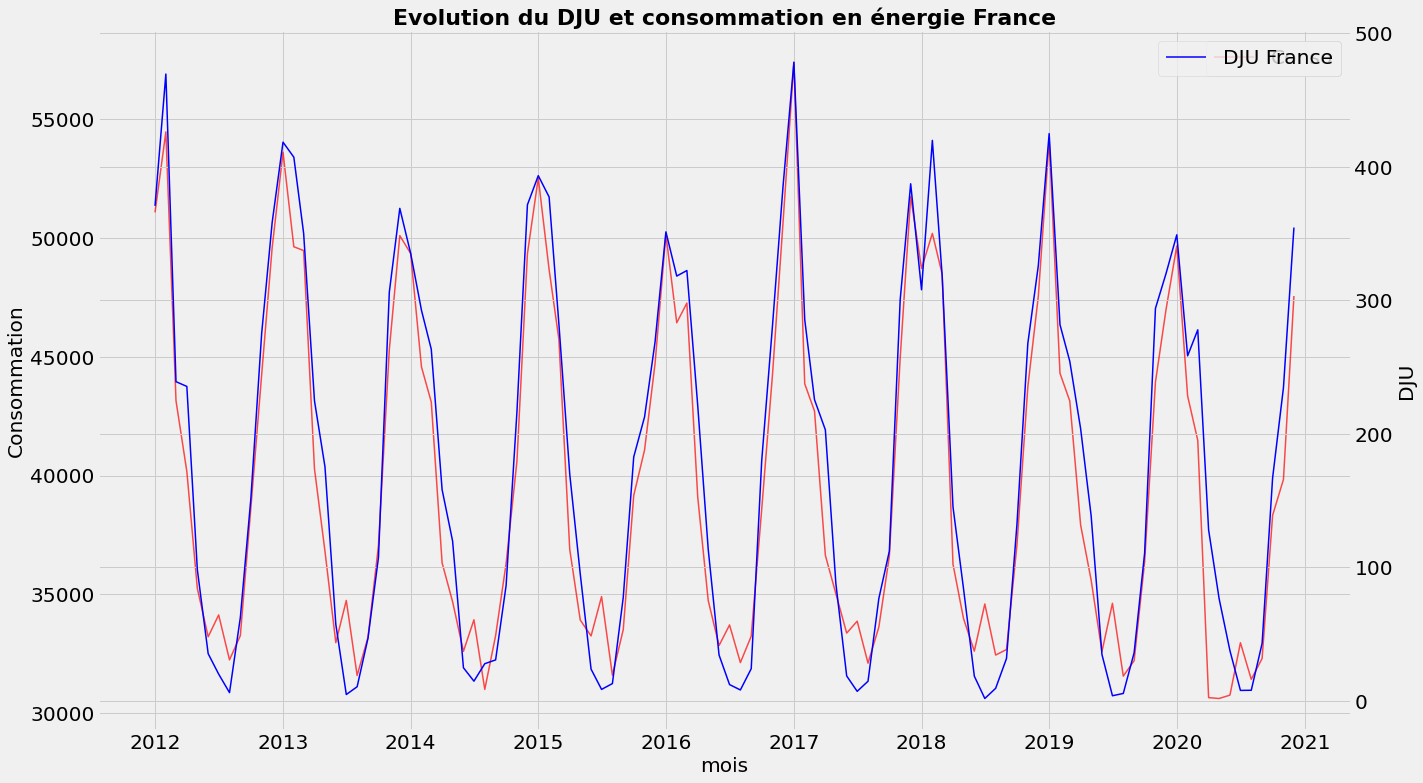

In [16]:
fig = plt.figure(figsize=(20,12))
ax1 = sns.lineplot(data=df_conso, x=df_conso.index,  y="Consommation", color="red", alpha=0.7, legend='brief', label="Conso")
ax2 = plt.twinx()
ax2 = sns.lineplot(data=df_conso, x=df_conso.index,  y="DJU", color="blue", ax=ax2, legend='brief', label="DJU France")
plt.title("Evolution du DJU et consommation en énergie France", fontsize=22)

plt.savefig('03. Evolution du DJU et consommation en énergie France.png')
plt.show()

Les 2 courbes semblent suivre la même saisonnalité ce qui indique bien que les variations de la courbe de consommation d'énergie sont effectivement globalement liées aux écarts de températures.

### Correction des données de l'effet température

In [17]:
df_conso.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 2012-01-01 to 2020-12-01
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Consommation  108 non-null    int64  
 1   DJU           108 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 6.6 KB


In [18]:
df_conso.describe()

,Consommation,DJU
count,108.000000,108.000000
mean,39737.250000,179.772106
std,7086.595702,140.022779
min,30622.000000,1.862500
25%,33347.750000,35.256250
50%,37082.500000,168.406250
75%,45047.500000,295.628125
max,57406.000000,478.275000


#### Régression linéaire

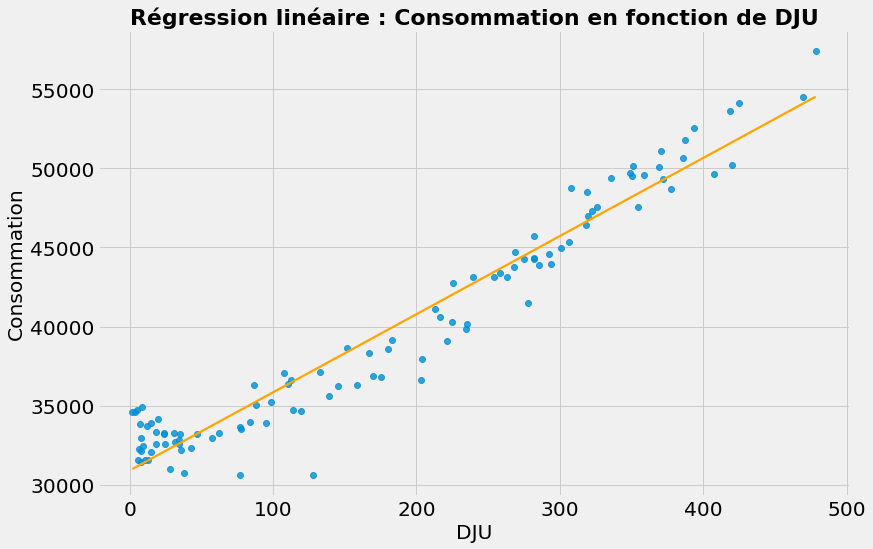

In [19]:
fig = plt.figure(figsize=(12,8))
ax = sns.regplot(data=df_conso, x="DJU", y="Consommation", robust=True, ci=None, line_kws={"color":"orange"})
plt.title("Régression linéaire : Consommation en fonction de DJU", fontsize=22)

plt.savefig('04. Régression linéaire.png')
plt.show()

In [20]:
lr = smf.ols('Consommation ~ DJU', data=df_conso).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:           Consommation   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     1627.
Date:                Tue, 02 Aug 2022   Prob (F-statistic):           3.86e-66
Time:                        12:18:51   Log-Likelihood:                -959.38
No. Observations:                 108   AIC:                             1923.
Df Residuals:                     106   BIC:                             1928.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.092e+04    276.547    111.813      0.0

Ici, le  est de l'ordre de 0.94, ce qui est élévé et au vu de la représentation graphique de notre droite de régression, cela nous indique que le modèle est bon. La variable "dju" est également statistiquement significative au niveau de test 5%, sa P-value étant de 0.

In [21]:
df_conso['Consommation corrigée'] = df_conso['Consommation'] - (df_conso['DJU'] * lr.params['DJU']).astype(int)
df_conso.head()

,Consommation,DJU,Consommation corrigée
mois,,,
2012-01-01,51086,370.7375,32906
2012-02-01,54476,469.4625,31455
2012-03-01,43156,239.1000,31432
2012-04-01,40176,235.5375,28626
2012-05-01,35257,98.3875,30433


Visualisation de la consommation en électricité avant et après correction

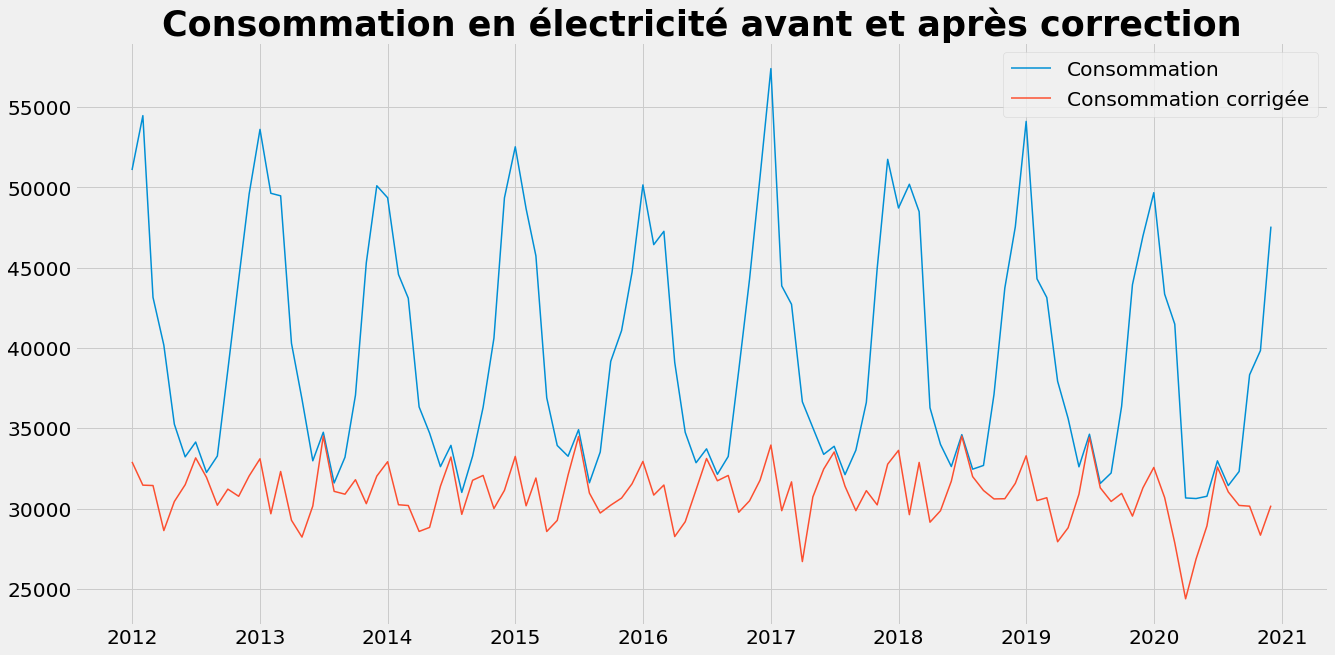

In [22]:
plt.plot(df_conso['Consommation'], label='Consommation')
plt.plot(df_conso['Consommation corrigée'], label='Consommation corrigée')
plt.title('Consommation en électricité avant et après correction')

plt.legend()
plt.savefig('05.Consommation en électricité avant et après correction.png')
plt.show()

In [23]:
df_conso.to_csv('df_conso.csv')

On voit ici clairement l'impact des températures sur les consommation d'énergie au niveau national. Il existe encore sur cette série temporelle corrigée un fort impact saisonnier.

Nous allons donc effectuer une désaisonnalisation de la consommation corrigée des effets de température par la méthode des moyennes mobiles.

#### Test de normalité des résidus

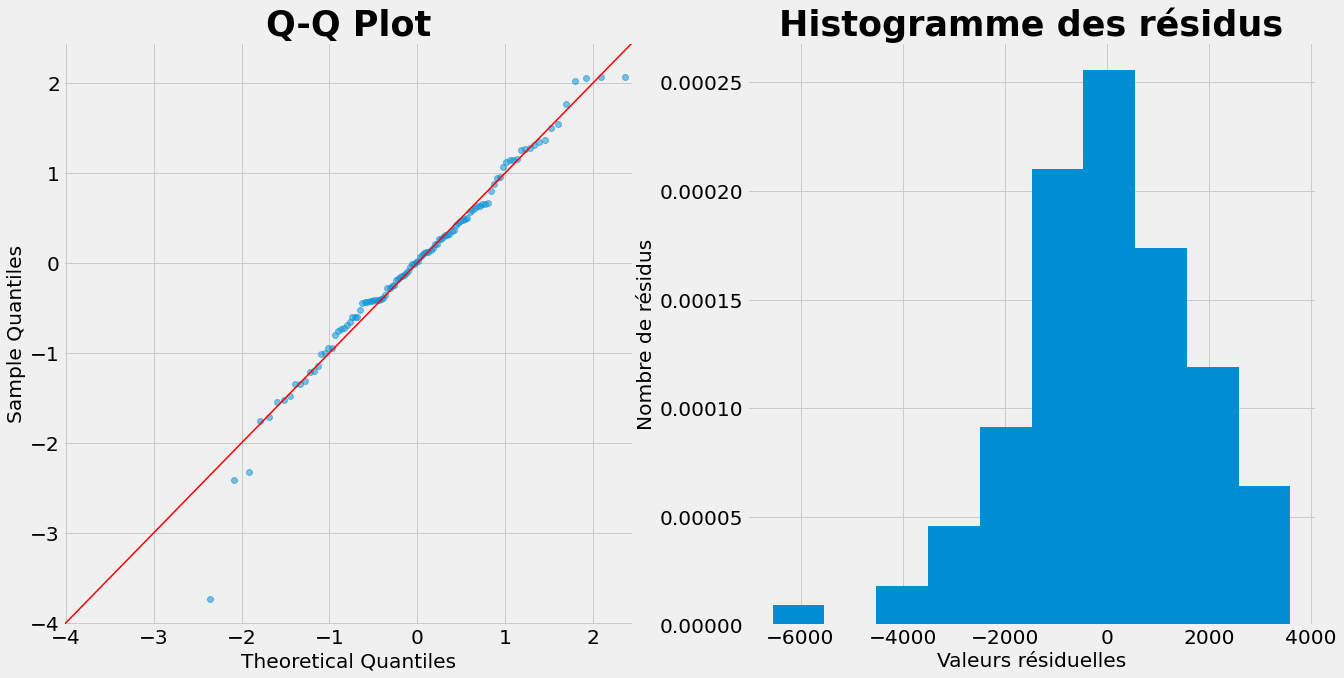

In [24]:
#Distribution des résidus
fig, ax = plt.subplots(1, 2, figsize=(20,10))

plt.hist(lr.resid, density=True)

model_norm_residuals = lr.get_influence().resid_studentized_internal
QQ = ProbPlot(model_norm_residuals)
QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', ax=ax[0])

ax[0].set_title('Q-Q Plot')
ax[1].set_title('Histogramme des résidus')
ax[1].set_xlabel('Valeurs résiduelles')
ax[1].set_ylabel('Nombre de résidus')

plt.savefig('06. Test normalité des résidus.png')                
plt.show()

In [25]:
#Test de Shapiro-Wilk
shapiro(lr.resid)

ShapiroResult(statistic=0.9797238707542419, pvalue=0.09829360991716385)

### Mission 2 : 
Effectuez une désaisonnalisation de la consommation que vous aurez obtenue après correction, grâce aux moyennes mobiles.

Une moyenne mobile est une combinaison linéaire d'instants passés et futurs de notre série temporelle. L'enjeu est de trouver une moyenne mobile qui laisse la tendance invariante, qui absorbe la saisonnalité et qui réduit le résidu.

La méthode seasonal_decompose de statsmodels permet de visualiser la tendance, la saisonnalité et le résidu du signal.

<AxesSubplot:xlabel='mois'>

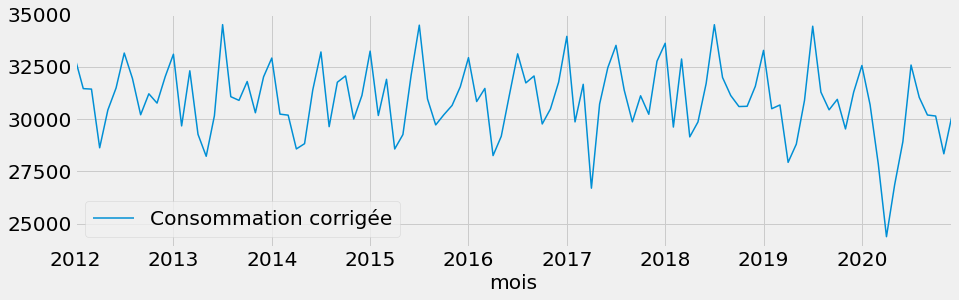

In [26]:
df_conso.plot(y="Consommation corrigée", figsize=(14,4))

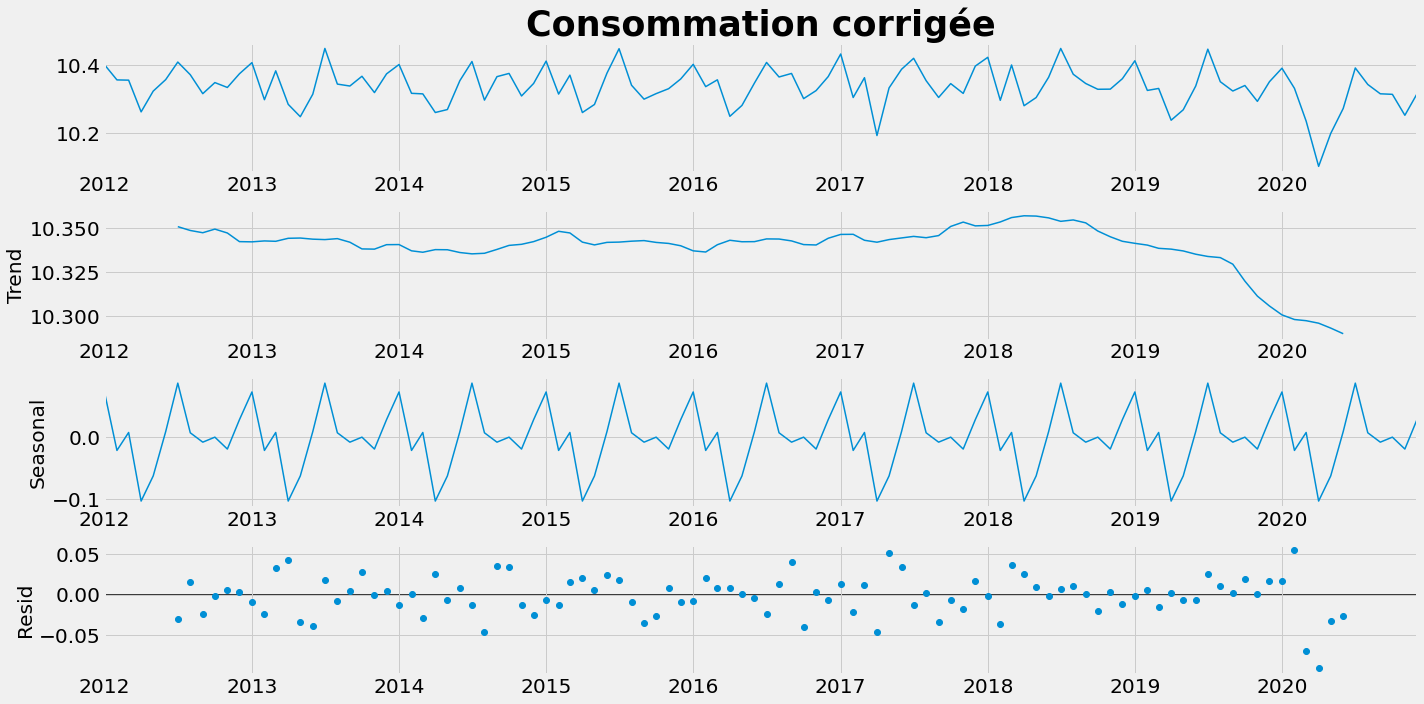

In [27]:
x = df_conso["Consommation corrigée"]
y = np.log(x)
decomp_y = seasonal_decompose(y,  model='additive')
decomp_y.plot()

plt.savefig('07. Décomposition.png')
plt.show()

On peut voir sur ce graphique combiné la décomposition de la tendance et de la saisonnalité ainsi que les résidus. Nous allons placer les valeurs de la décomposition dans un dataframe Pandas :

In [28]:
df_decomp_y_seasonal = pd.DataFrame(decomp_y.seasonal)
y_compl = pd.merge(y, df_decomp_y_seasonal, on="mois")
y_compl["cvs"] = np.exp(y_compl["Consommation corrigée"] - y_compl["seasonal"])
y_compl

,Consommation corrigée,seasonal,cvs
mois,,,
2012-01-01,10.401410,0.073381,30577.802152
2012-02-01,10.356313,-0.021284,32131.668765
2012-03-01,10.355582,0.007778,31188.472407
2012-04-01,10.262071,-0.103246,31739.482106
2012-05-01,10.323283,-0.062565,32397.856415
...,...,...,...
2020-08-01,10.342871,0.007263,30810.397747
2020-09-01,10.315365,-0.007905,30432.622807
2020-10-01,10.313774,0.000203,30138.882914


Visualisation de la consommation en électricité avant et après désaisonnalisation

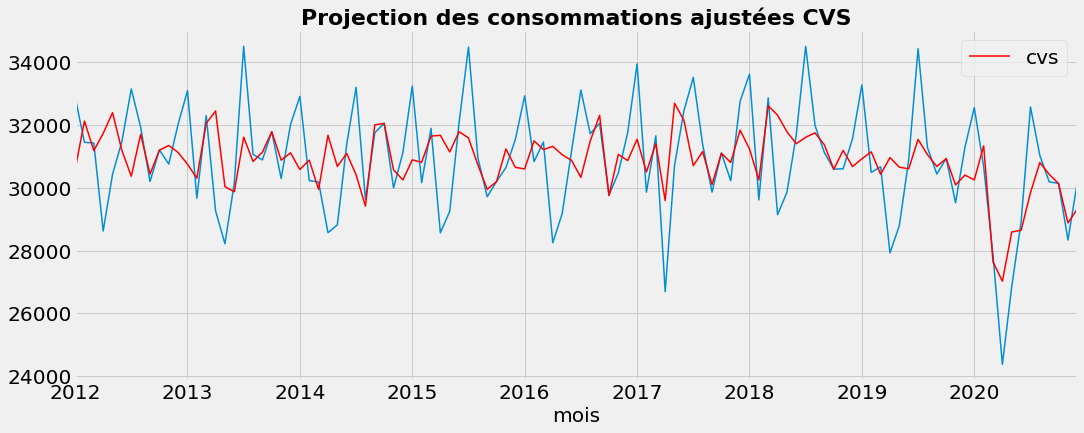

In [29]:
x.plot(figsize=(16,6))
y_compl["cvs"].plot(legend = True, color="r")
plt.title("Projection des consommations ajustées CVS", fontsize=22)

plt.savefig('08. Consommation en électricité avant et après désaisonnalisation.png')
plt.show()

In [30]:
df_conso["Conso_ajuste_cvs"] = y_compl["cvs"]
df_conso

,Consommation,DJU,Consommation corrigée,Conso_ajuste_cvs
mois,,,,
2012-01-01,51086,370.7375,32906,30577.802152
2012-02-01,54476,469.4625,31455,32131.668765
2012-03-01,43156,239.1000,31432,31188.472407
2012-04-01,40176,235.5375,28626,31739.482106
2012-05-01,35257,98.3875,30433,32397.856415
...,...,...,...,...
2020-08-01,31428,8.0250,31035,30810.397747
2020-09-01,32307,43.1125,30193,30432.622807
2020-10-01,38332,166.9625,30145,30138.882914


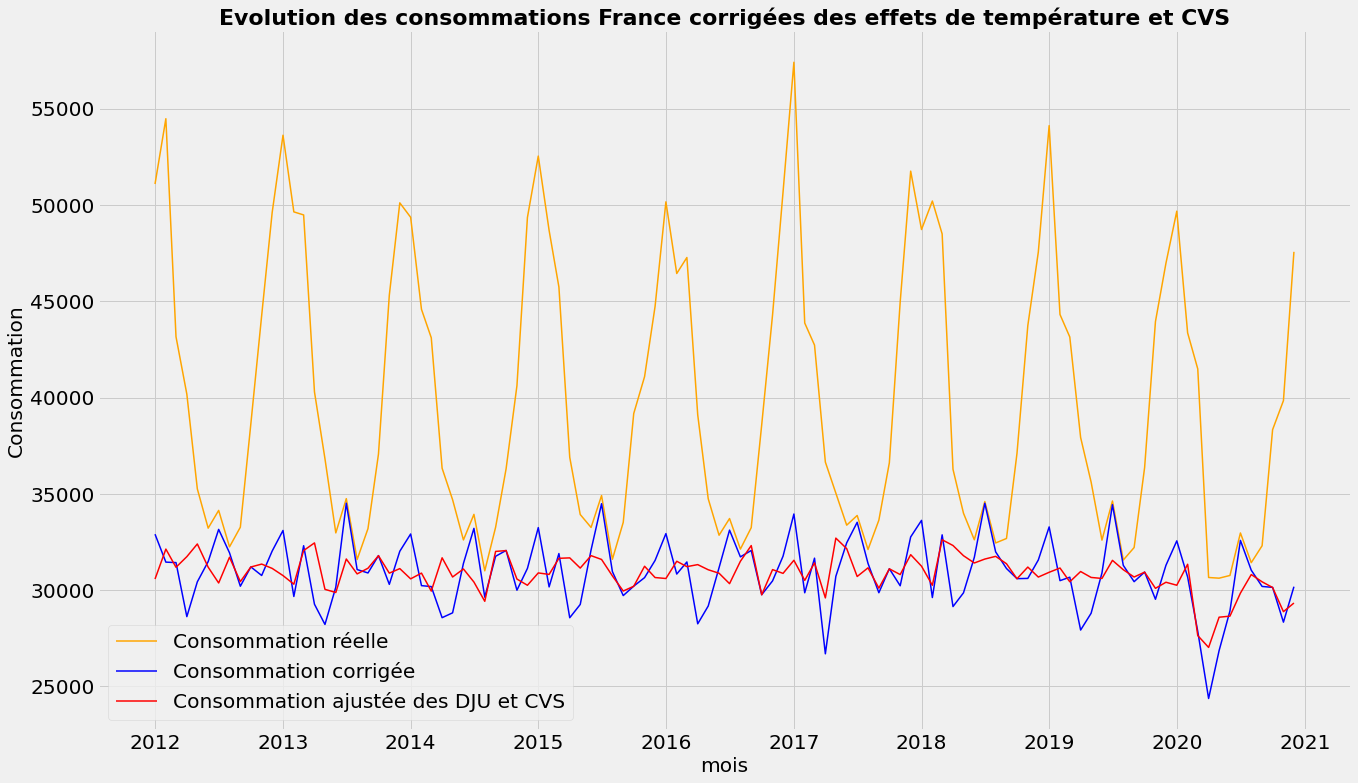

In [31]:
fig = plt.figure(figsize=(20,12))
ax1 = sns.lineplot(data=df_conso, x=df_conso.index,  y="Consommation", color="orange", legend='brief', label="Consommation réelle")
#ax1.lines[0].set_linestyle("--")
ax2 = sns.lineplot(data=df_conso, x=df_conso.index,  y="Consommation corrigée", color="blue", legend='brief', label="Consommation corrigée")
ax3 = sns.lineplot(data=df_conso, x=df_conso.index,  y="Conso_ajuste_cvs", color="red", legend='brief', label="Consommation ajustée des DJU et CVS")
plt.title("Evolution des consommations France corrigées des effets de température et CVS", fontsize=22)

plt.savefig('09. Evolution des consommations France corrigées des effets de température et CVS.png')
plt.show()

### Mission 3

Effectuez une prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temporelle.

#### Méthode de Holt-Winters (lissage exponentiel)
Pour cette prévision, nous allons utiliser la série corrigée des effets de température

Nous allons travailler sur la série de 2012 à 2019 afin de tenter de prévoir l'année 2020 pour comparer la prévision au données réelles.
Nous utiliserons la fonction ExponentialSmoothing de Statsmodels :

In [32]:
x_train = x["2012":"2019"]
x_test = x["2020"]
y_train = np.log(x_train)
y_test = np.log(x_test)

In [33]:
from statsmodels.tsa.api import ExponentialSmoothing
hw_ln = ExponentialSmoothing(np.asarray(y_train), seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred_ln = hw_ln.forecast(12)

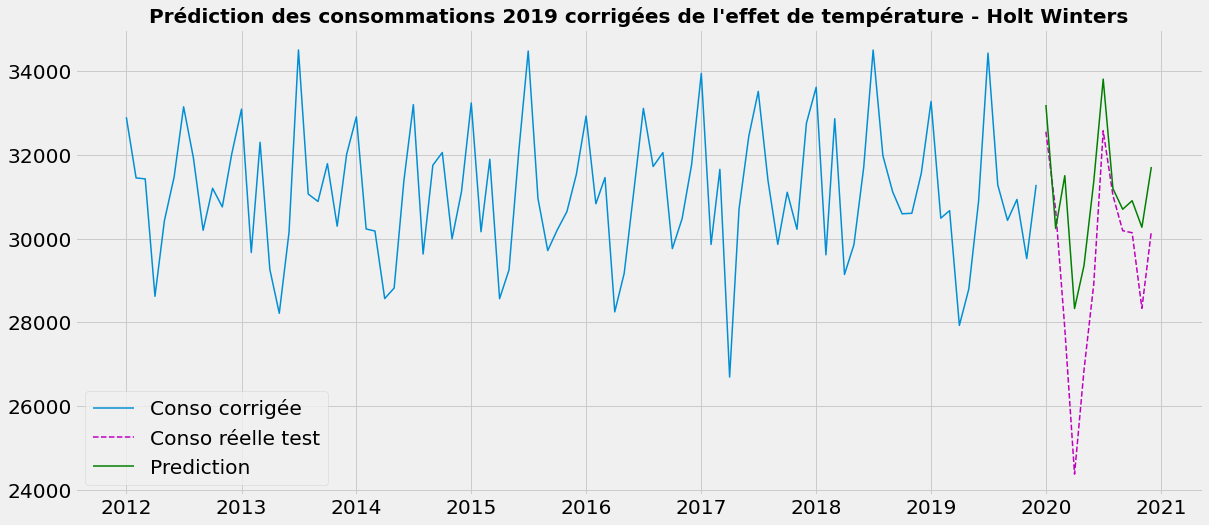

In [34]:
plt.figure(figsize=(18, 8))
plt.plot(x_train, label='Conso corrigée')
plt.plot(x_test, label='Conso réelle test', color="m", linestyle="--")
plt.plot(y_test.index, np.exp(hw_pred_ln), label='Prediction', color="g")
plt.title("Prédiction des consommations 2019 corrigées de l'effet de température - Holt Winters", fontsize=20)
plt.legend()
plt.savefig('11. Prédiction de la consommation d\'énergie par la méthode de Holt-Winters.png')
plt.show()

Visualisation par restriction sur l'année de prévision et n-1 

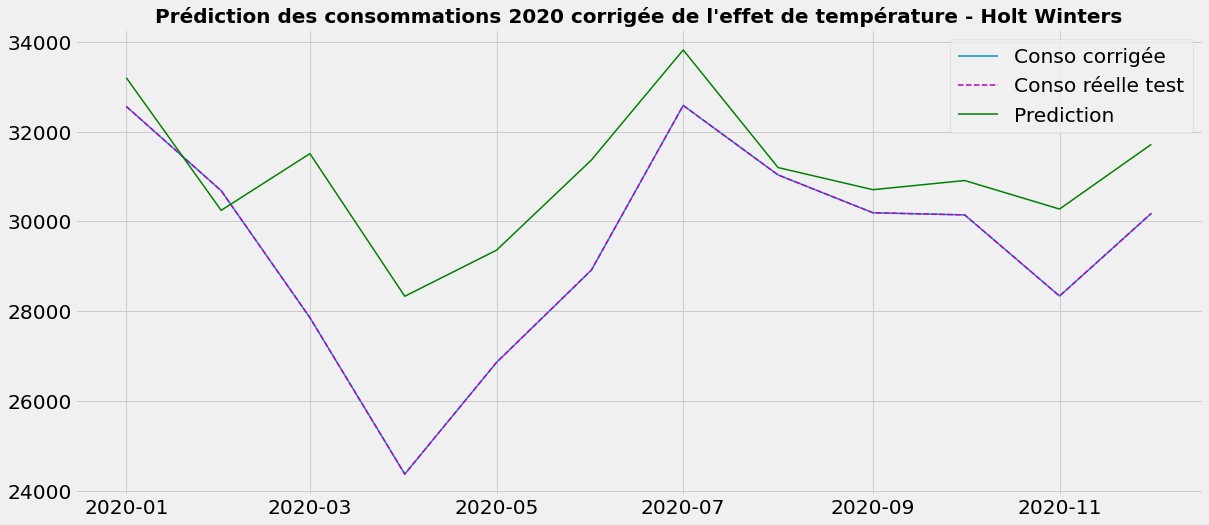

In [35]:
plt.figure(figsize=(18, 8))

plt.plot(x["2020":], label='Conso corrigée')
plt.plot(x_test, label='Conso réelle test', color="m", linestyle="--")
plt.plot(y_test.index, np.exp(hw_pred_ln), label='Prediction', color='g')
plt.title("Prédiction des consommations 2020 corrigée de l'effet de température - Holt Winters", fontsize=20)
plt.legend()

plt.savefig("12. p9_holt-winters.png")
plt.show()

### Méthode SARIMA

Nous allons tout d'abord tester la stationnarité de notre série temporelle avec le test ADF (Augmented Dickey-Fuller).

In [36]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
#ADF-test(Série originelle)
res_adf_o = adfuller(x,regression='ct')
print('p-value ADF série originelle :{}'.format(res_adf_o[1]))

p-value ADF série originelle :0.9970236275371385


In [37]:
#ADF-test(Série différenciée)
res_adf_d = adfuller(x.diff().dropna(),regression='c')
print('p-value ADF série différenciée :{}'.format(res_adf_d[1]))

p-value ADF série différenciée :1.5326396517077413e-19


Au niveau de test 5%, on  rejette l'hypothèse de non-stationnarité de la série.

### Stationnarisation

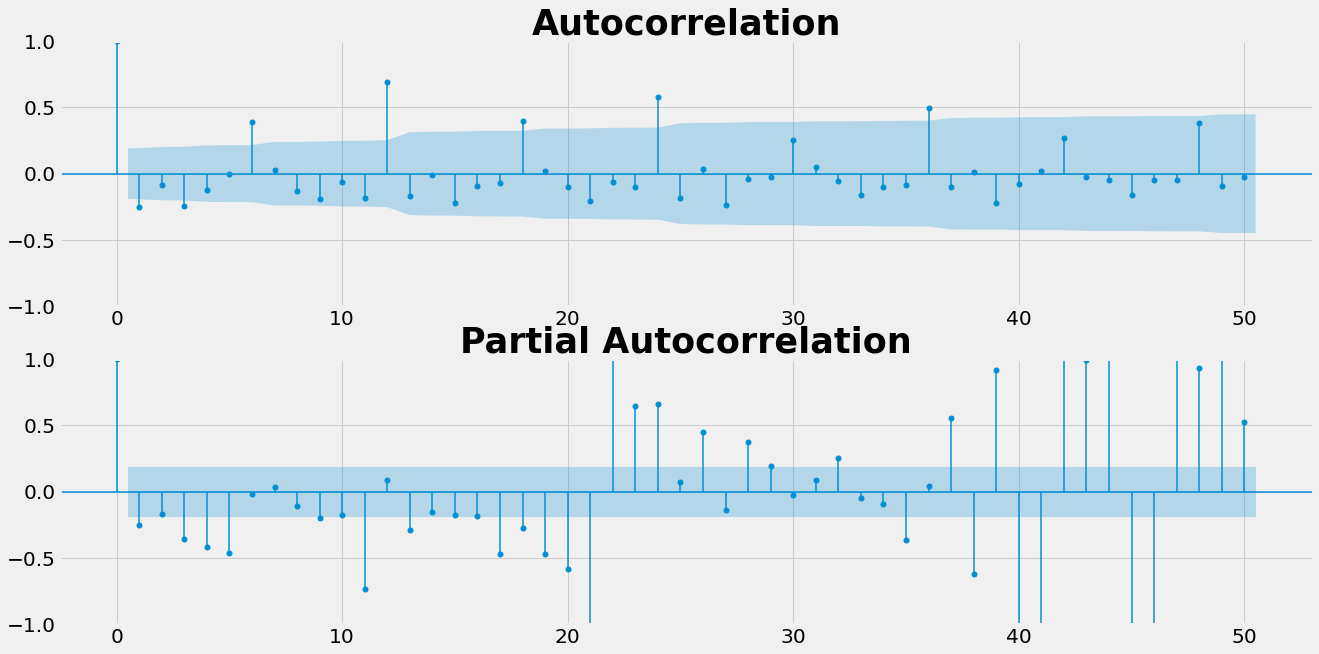

In [38]:
fig,ax = plt.subplots(2,1,figsize=(20 ,10))
fig = sm.graphics.tsa.plot_acf(y.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(y.diff().dropna(), lags=50, ax=ax[1])
plt.show()

In [39]:
y_diff_6 = y.diff(6)

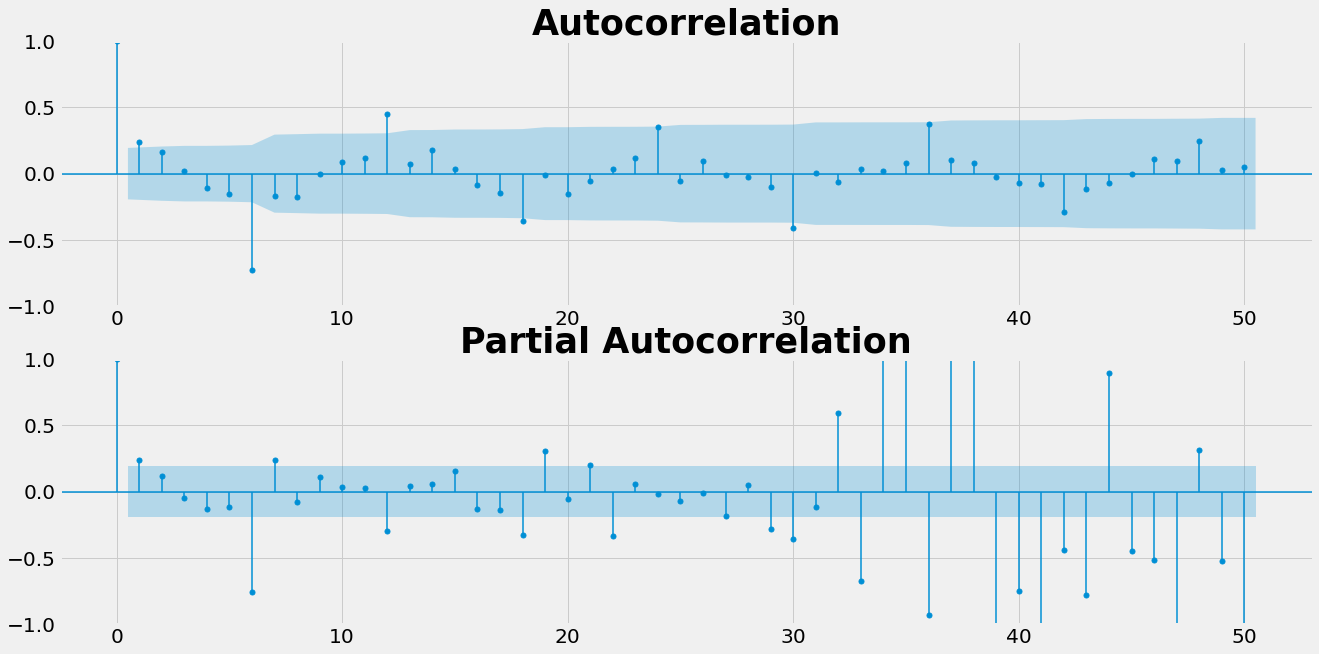

In [40]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(y_diff_6.dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(y_diff_6.dropna(), lags=50, ax=ax[1])
plt.show()

### Estimation et validation des modèles
Modèle Sarima

In [41]:
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.stats.diagnostic import acorr_ljungbox

model = SARIMAX(np.asarray(y), order=(1,1,0), seasonal_order=(1,1,1,6))
results = model.fit()
residus = results.resid
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 6)   Log Likelihood                 177.541
Date:                             Tue, 02 Aug 2022   AIC                           -347.082
Time:                                     12:18:54   BIC                           -336.621
Sample:                                          0   HQIC                          -342.847
                                             - 108                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3882      0.081     -4.793      0.000      -0.547      -0.229
ar.S.L6       -0.5540      

In [42]:
shapiro(results.resid)

ShapiroResult(statistic=0.15230268239974976, pvalue=3.7156575472389456e-22)

In [43]:
def plot_diagnostics(sarima_res, variable=0, lags=10, fig=None, figsize=None):
        return type(sarima_res.plot_diagnostics(variable, lags, fig, figsize))

matplotlib.figure.Figure

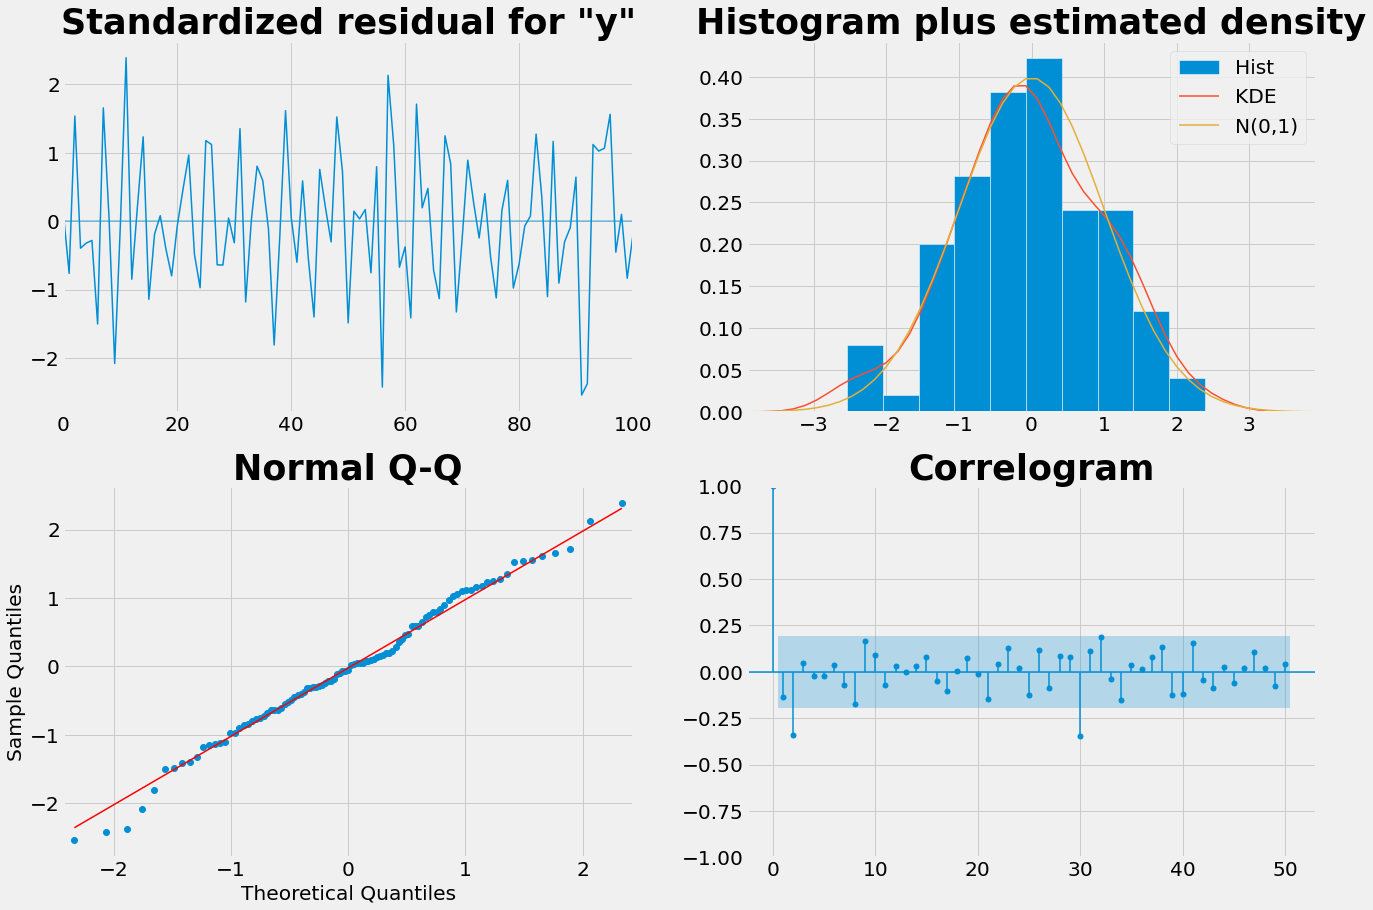

In [44]:
plot_diagnostics(sarima_res = results, figsize=(20,14), lags=50)

Le modèle semble donc performant, mais nous allons réaliser une Grid Search pour vérifier les autres paramètres avant de pouvoir effectuer nos tests à posteriori.

In [45]:
df_results_gs = pd.DataFrame(columns=["Modèle","AIC","MAPE","RMSE","MSE","MAE"])

def grid_search_sarima(season, y_train, y_test):
# Define the p, d and q parameters to take any value between 0 and 2
    configs = list()
    # Liste des config
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = season

    for p in p_params:
        for d in d_params:
            for q in q_params:
                for P in P_params:
                    for D in D_params:
                        for Q in Q_params:
                            for m in m_params:
                                cfg = [(p,d,q), (P,D,Q,m)]
                                configs.append(cfg)

    list_model = list()
    list_aic = list()
    list_mape = list()
    list_rmse = list()
    list_mse = list()
    list_mae = list()

    for config_sarima in configs:
        order, seasonal_order = config_sarima
        try:
            model = sm.tsa.statespace.SARIMAX(y_train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit(disp=False)
            pred_model = results.get_forecast(12)
            pred = pred_model.predicted_mean

            #metriques
            y_true, y_pred = np.array(np.exp(y_test)), np.array(np.exp(pred))
            diff = y_true - y_pred
            mae = np.mean(abs(diff))
            mse = np.mean(diff**2)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs(diff / y_true)) * 100
            #print('SARIMA{}x{} - AIC:{} - MAPE:{}'.format(order, seasonal_order, results.aic, mape))

            str_model = str(order) + str(seasonal_order)
            list_model.append(str_model)
            list_aic.append(results.aic)
            list_mape.append(mape)
            list_rmse.append(rmse)
            list_mse.append(mse)
            list_mae.append(mae)

        except:
            continue

    df_results_gs["Modèle"] = list_model
    df_results_gs["AIC"] = list_aic
    df_results_gs["MAPE"] = list_mape
    df_results_gs["RMSE"] = list_rmse
    df_results_gs["MSE"] = list_mse
    df_results_gs["MAE"] = list_mae

    return df_results_gs

grid_search_sarima([6,12],y_train,y_test)

,Modèle,AIC,MAPE,RMSE,MSE,MAE
0,"(0, 0, 0)(0, 0, 0, 6)",715.502299,99.996586,29563.397845,8.739945e+08,29476.500000
1,"(0, 0, 0)(0, 0, 0, 12)",715.502299,99.996586,29563.397845,8.739945e+08,29476.500000
2,"(0, 0, 0)(0, 0, 1, 6)",571.598784,99.666865,29475.607194,8.688114e+08,29384.317188
3,"(0, 0, 0)(0, 0, 1, 12)",548.176413,99.431570,29399.043845,8.643038e+08,29311.287368
4,"(0, 0, 0)(0, 0, 2, 6)",463.427904,97.184350,28814.922605,8.302998e+08,28685.081926
...,...,...,...,...,...,...
643,"(2, 1, 2)(2, 1, 0, 12)",-238.782183,5.996097,2060.359970,4.245083e+06,1685.696845
644,"(2, 1, 2)(2, 1, 1, 6)",-299.429553,5.027360,1809.615368,3.274708e+06,1392.777174
645,"(2, 1, 2)(2, 1, 1, 12)",-237.136048,5.969977,2033.071338,4.133379e+06,1680.394379
646,"(2, 1, 2)(2, 1, 2, 6)",-292.886816,4.633894,1721.977556,2.965207e+06,1282.105391


In [46]:
model2 = SARIMAX(np.asarray(y), order=(1,0,1), seasonal_order=(1,0,1,12))
results2 = model2.fit()
residus2 = results2.resid
print(results2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 200.495
Date:                            Tue, 02 Aug 2022   AIC                           -390.989
Time:                                    12:21:40   BIC                           -377.578
Sample:                                         0   HQIC                          -385.551
                                            - 108                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.000   3287.498      0.000       0.999       1.001
ma.L1         -0.9072      0.035   

In [47]:
shapiro(results2.resid)

ShapiroResult(statistic=0.0894046425819397, pvalue=7.802194073208588e-23)

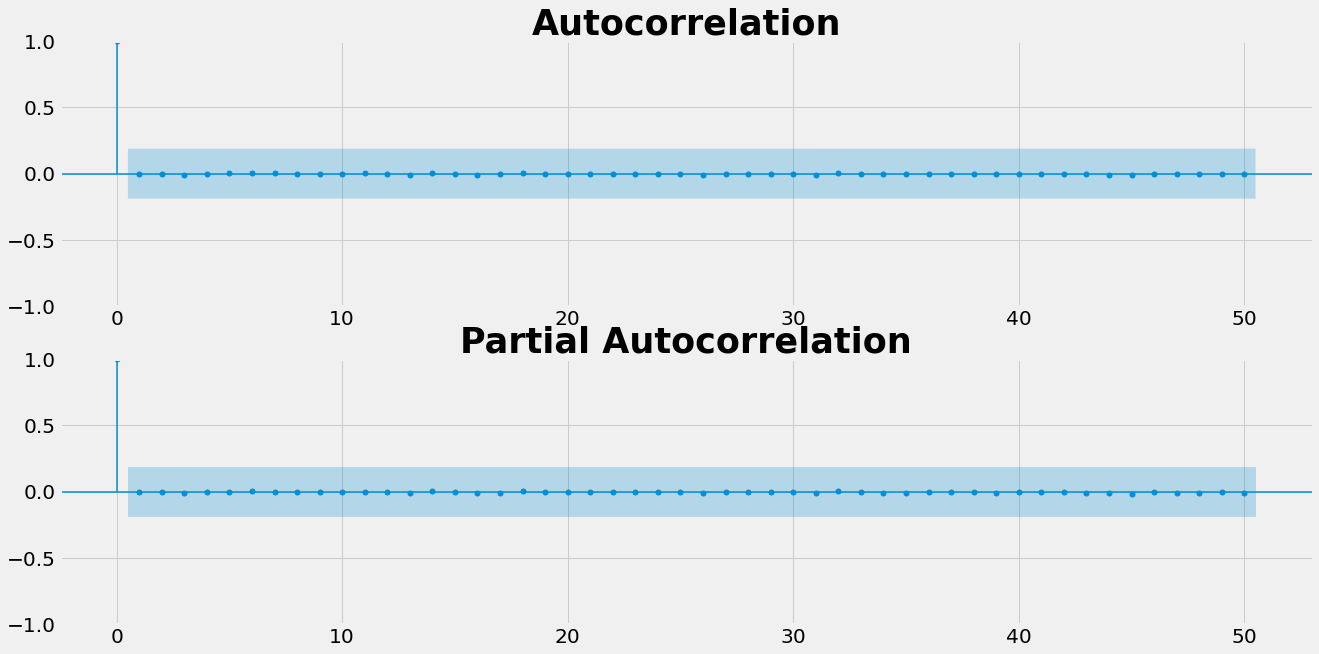

In [48]:
fig, ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(residus2, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(residus2, lags=50, ax=ax[1])
plt.show()

matplotlib.figure.Figure

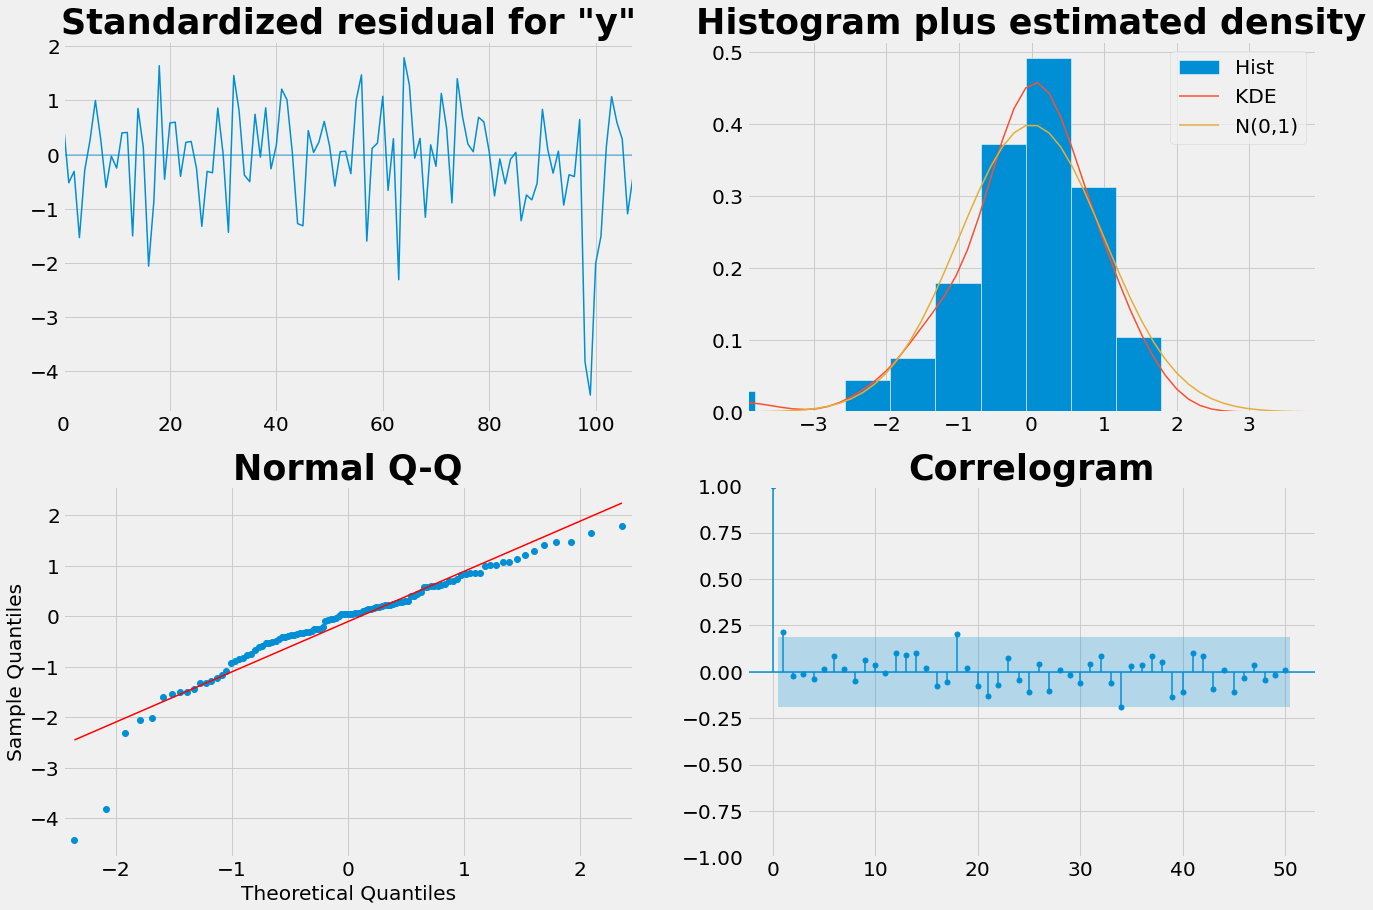

In [49]:
plot_diagnostics(sarima_res = results2, figsize=(20,14), lags=50)

Modèle 2 plus performant en tout point que le modèle 1 

### Analyse à posteriori
Nous allons à nouveau utiliser le split de notre série temporelle pour obtenir un jeu de test et un jeu d'entrainement. Nous pourrons ensuite estimer notre prévision comparativement aux données réelles.

Vérifions si notre modèle est toujours optimal sur nos données d'entrainement :

In [50]:
model_train = SARIMAX(np.asarray(y_train), order=(1,0,1), seasonal_order=(1,0,1,12))
results_train = model_train.fit()
print(results_train.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 196.072
Date:                            Tue, 02 Aug 2022   AIC                           -382.144
Time:                                    12:21:41   BIC                           -369.323
Sample:                                         0   HQIC                          -376.962
                                             - 96                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   6.85e-05   1.46e+04      0.000       1.000       1.000
ma.L1         -0.9600      0.090   

In [51]:
shapiro(results_train.resid)

ShapiroResult(statistic=0.09350395202636719, pvalue=1.3154059957055877e-21)

matplotlib.figure.Figure

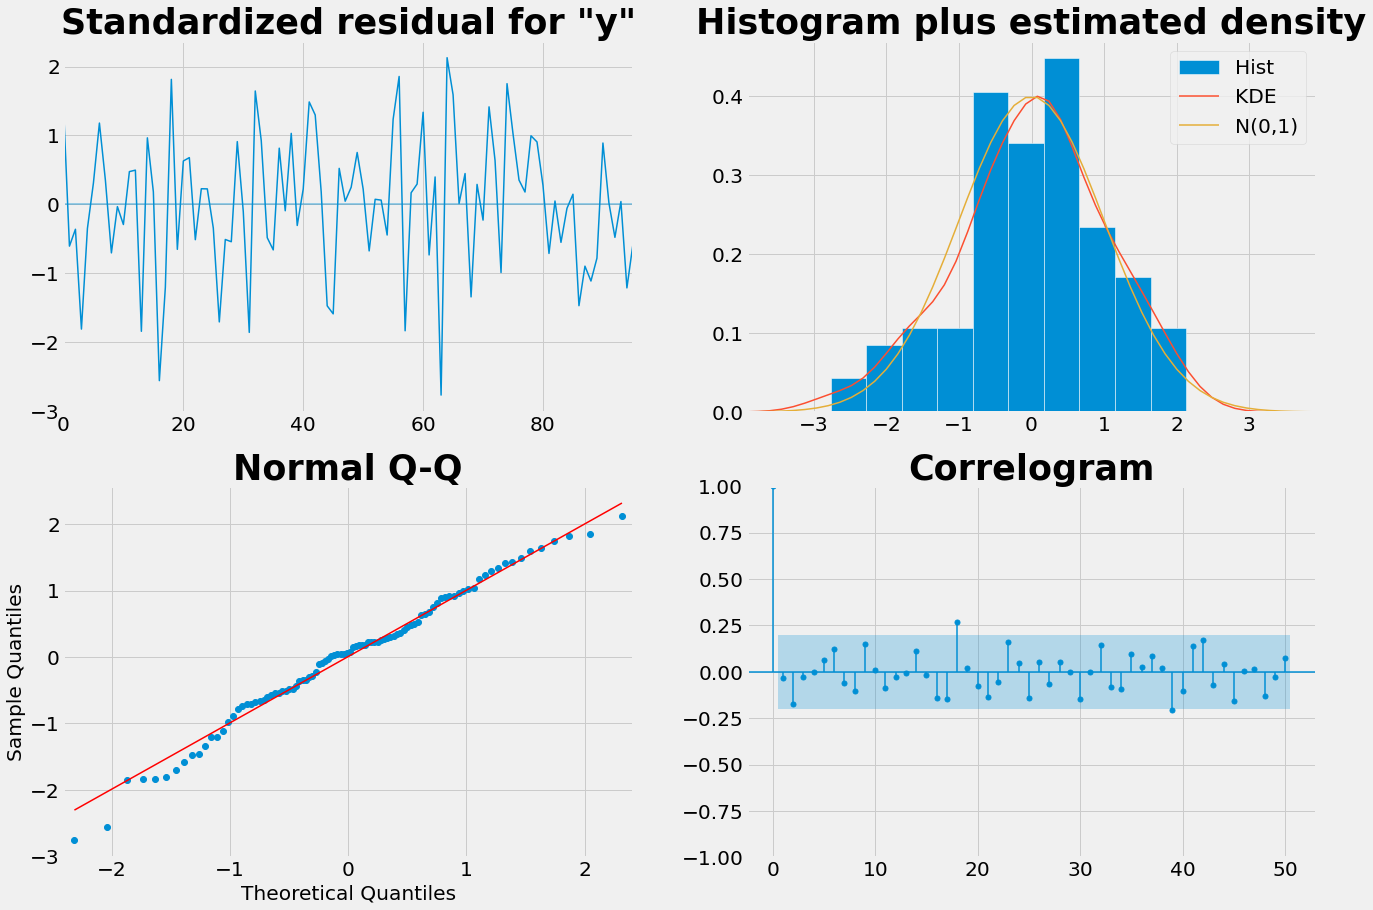

In [52]:
plot_diagnostics(sarima_res = results_train, figsize=(20,14), lags=50)

#### Prédiction

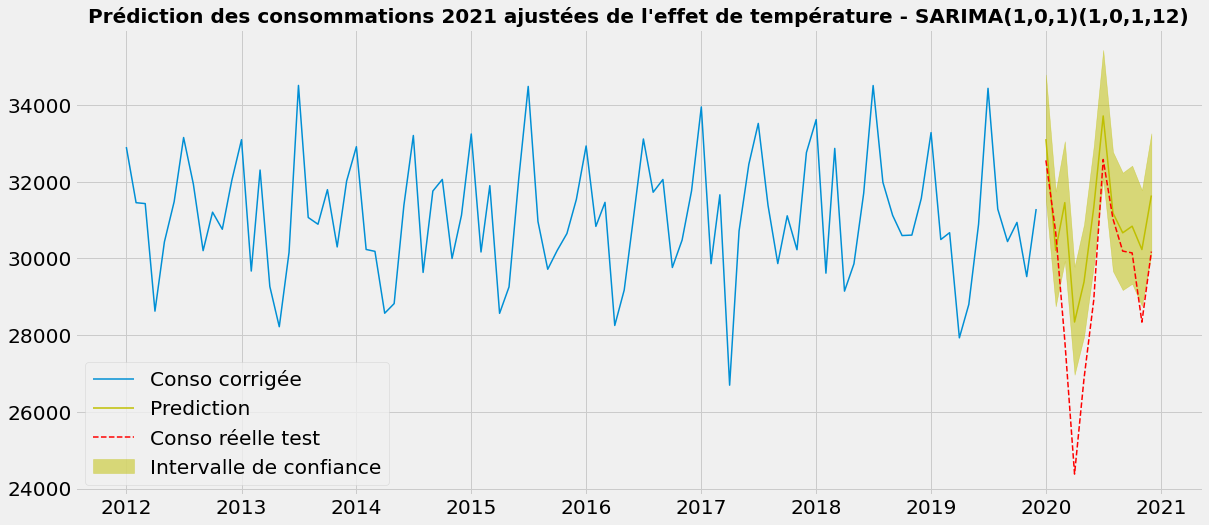

In [53]:
pred_model = results_train.get_forecast(12)
pred = pred_model.predicted_mean
#Intervals de prévisions à 5%
pred_ci = pred_model.conf_int(alpha=0.05)

plt.figure(figsize=(18, 8))
plt.plot(x_train, label='Conso corrigée')
plt.plot(y_test.index, np.exp(pred), color='y', label='Prediction')
plt.plot(np.exp(y_test), label='Conso réelle test', color="r", linestyle="--")
plt.fill_between(y_test.index, np.exp(pred_ci[:,0]), np.exp(pred_ci[:,1]), alpha=0.5, color="y", label="Intervalle de confiance")
plt.title("Prédiction des consommations 2021 ajustées de l'effet de température - SARIMA(1,0,1)(1,0,1,12)", fontsize=20)
plt.legend()

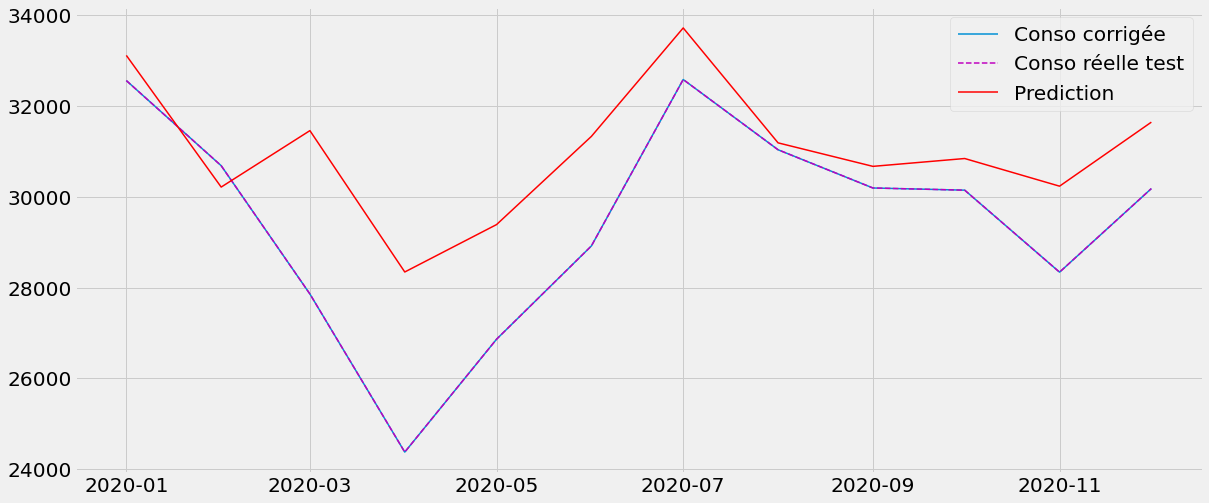

In [54]:
plt.figure(figsize=(18, 8))
plt.plot(x["2020":], label='Conso corrigée')
plt.plot(x_test, label='Conso réelle test', color="m", linestyle="--")
plt.plot(y_test.index, np.exp(pred), color='r', label='Prediction')
plt.legend()

plt.show()

### Prévision des consommations pour l'année 2021

Méthode Holt-Winters

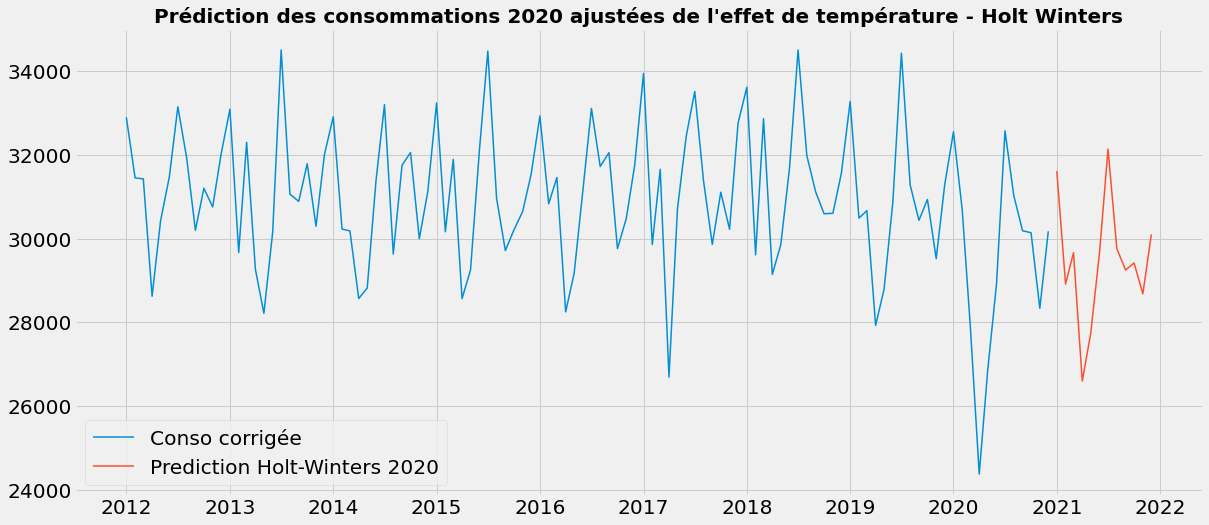

In [55]:
hw_ln_2021 = ExponentialSmoothing(np.asarray(y), seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred_ln_2021 = hw_ln_2021.forecast(12)

plt.figure(figsize=(18,8))
plt.plot(x, label='Conso corrigée')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), np.exp(hw_pred_ln_2021), label='Prediction Holt-Winters 2020')
plt.title("Prédiction des consommations 2020 ajustées de l'effet de température - Holt Winters", fontsize=20)
plt.legend()
plt.show()

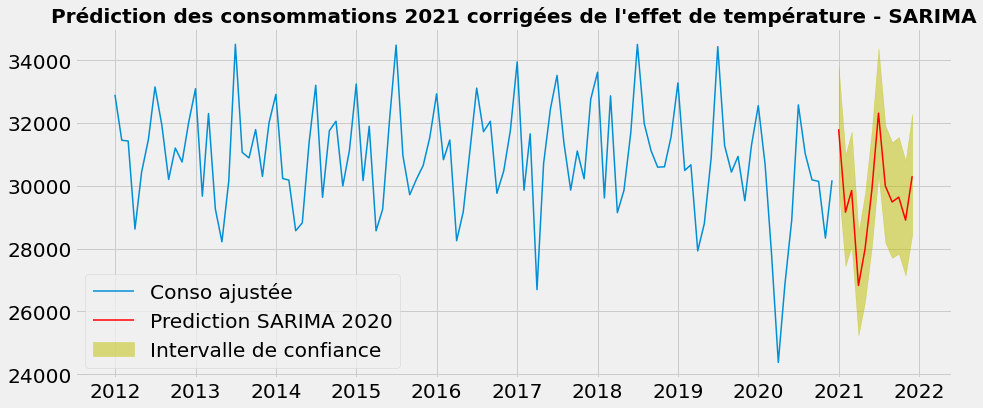

In [57]:
pred_model_2021 = results2.get_forecast(12)
pred_2021 = pred_model_2021.predicted_mean
#Intervals de prévisions à 5%
pred_ci_2021 = pred_model_2021.conf_int(alpha=0.05)

plt.figure(figsize=(14,6))
plt.plot(x, label='Conso ajustée')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), np.exp(pred_2021), color='r', label='Prediction SARIMA 2020')
plt.fill_between(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), np.exp(pred_ci_2021[:,0]), 
                 np.exp(pred_ci_2021[:,1]), alpha=0.5, color="y", label="Intervalle de confiance")
plt.title("Prédiction des consommations 2021 corrigées de l'effet de température - SARIMA", fontsize=20)
plt.legend()
plt.show()

#### Comparaison des deux méthodes

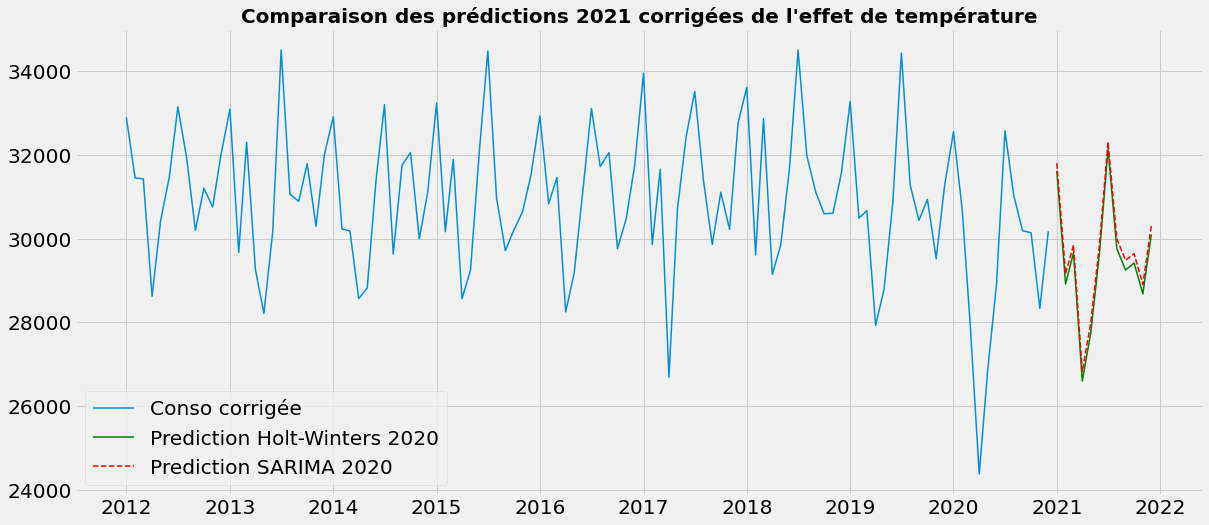

In [58]:
plt.figure(figsize=(18,8))
plt.plot(x, label='Conso corrigée')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), np.exp(hw_pred_ln_2021), color='g',label='Prediction Holt-Winters 2020')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), np.exp(pred_2021), color='r', linestyle="--", label='Prediction SARIMA 2020')
plt.title("Comparaison des prédictions 2021 corrigées de l'effet de température", fontsize=20)
plt.legend()


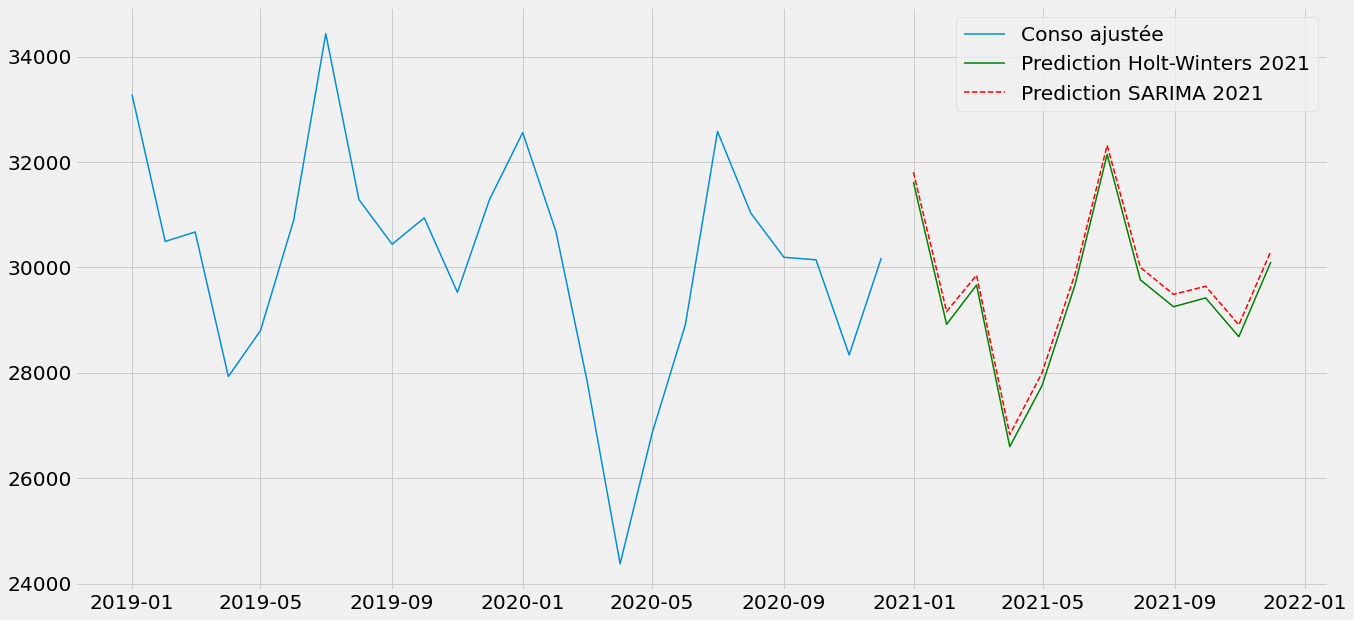

In [60]:
plt.plot(x["2019":], label='Conso ajustée')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), np.exp(hw_pred_ln_2021), color='g',label='Prediction Holt-Winters 2021')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), np.exp(pred_2021), color='r', linestyle="--", label='Prediction SARIMA 2021')
plt.legend()

plt.show()